In [50]:
import pandas as pd
from IPython.display import display
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sbn
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.manifold import Isomap, TSNE
from sklearn.cluster import KMeans
import scipy.cluster.hierarchy as sch
from sklearn.cluster import AgglomerativeClustering
import plotly.express as px
import warnings

In [2]:
warnings.simplefilter(action='ignore', category=FutureWarning)

In [3]:
data = pd.read_csv("Crop_recommendation.csv")

## Análisis Descriptivo

In [4]:
data.head()

N   P   K  temperature   humidity        ph    rainfall label
0  90  42  43    20.879744  82.002744  6.502985  202.935536  rice
1  85  58  41    21.770462  80.319644  7.038096  226.655537  rice
2  60  55  44    23.004459  82.320763  7.840207  263.964248  rice
3  74  35  40    26.491096  80.158363  6.980401  242.864034  rice
4  78  42  42    20.130175  81.604873  7.628473  262.717340  rice

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2200 entries, 0 to 2199
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   N            2200 non-null   int64  
 1   P            2200 non-null   int64  
 2   K            2200 non-null   int64  
 3   temperature  2200 non-null   float64
 4   humidity     2200 non-null   float64
 5   ph           2200 non-null   float64
 6   rainfall     2200 non-null   float64
 7   label        2200 non-null   object 
dtypes: float64(4), int64(3), object(1)
memory usage: 137.6+ KB


In [6]:
data.describe()

N            P            K  temperature     humidity  \
count  2200.000000  2200.000000  2200.000000  2200.000000  2200.000000   
mean     50.551818    53.362727    48.149091    25.616244    71.481779   
std      36.917334    32.985883    50.647931     5.063749    22.263812   
min       0.000000     5.000000     5.000000     8.825675    14.258040   
25%      21.000000    28.000000    20.000000    22.769375    60.261953   
50%      37.000000    51.000000    32.000000    25.598693    80.473146   
75%      84.250000    68.000000    49.000000    28.561654    89.948771   
max     140.000000   145.000000   205.000000    43.675493    99.981876   

                ph     rainfall  
count  2200.000000  2200.000000  
mean      6.469480   103.463655  
std       0.773938    54.958389  
min       3.504752    20.211267  
25%       5.971693    64.551686  
50%       6.425045    94.867624  
75%       6.923643   124.267508  
max       9.935091   298.560117

### Valores Nulos

<Axes: >

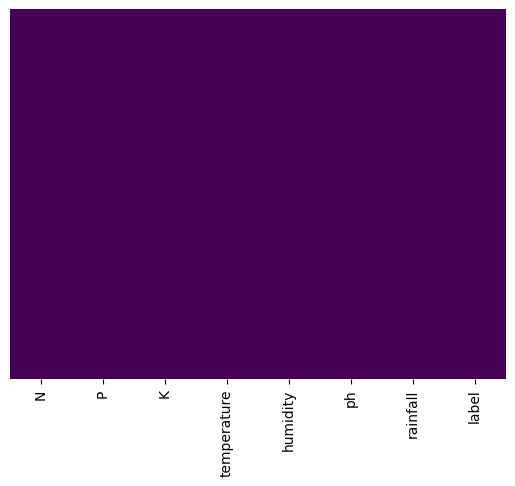

In [7]:
sbn.heatmap(data.isnull(), yticklabels=False, cbar=False, cmap="viridis")

No se ven valores nulos en ninguna columna

In [8]:
datax = data.drop("label", axis=1)
scaler = preprocessing.StandardScaler()
dataxScaled = pd.DataFrame(scaler.fit_transform(datax), columns=datax.columns)

In [9]:
dataxScaled.head()

N         P         K  temperature  humidity        ph  rainfall
0  1.068797 -0.344551 -0.101688    -0.935587  0.472666  0.043302  1.810361
1  0.933329  0.140616 -0.141185    -0.759646  0.397051  0.734873  2.242058
2  0.255986  0.049647 -0.081939    -0.515898  0.486954  1.771510  2.921066
3  0.635298 -0.556811 -0.160933     0.172807  0.389805  0.660308  2.537048
4  0.743673 -0.344551 -0.121436    -1.083647  0.454792  1.497868  2.898373

### Outliers

<Axes: >

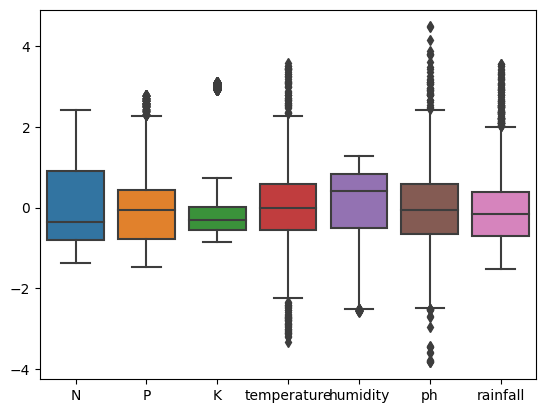

In [10]:
sbn.boxplot(dataxScaled)

Se ven valores atípicos en todas las variables menos la **N**. La que más tiene es **Rainfall**

/home/simon/.local/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


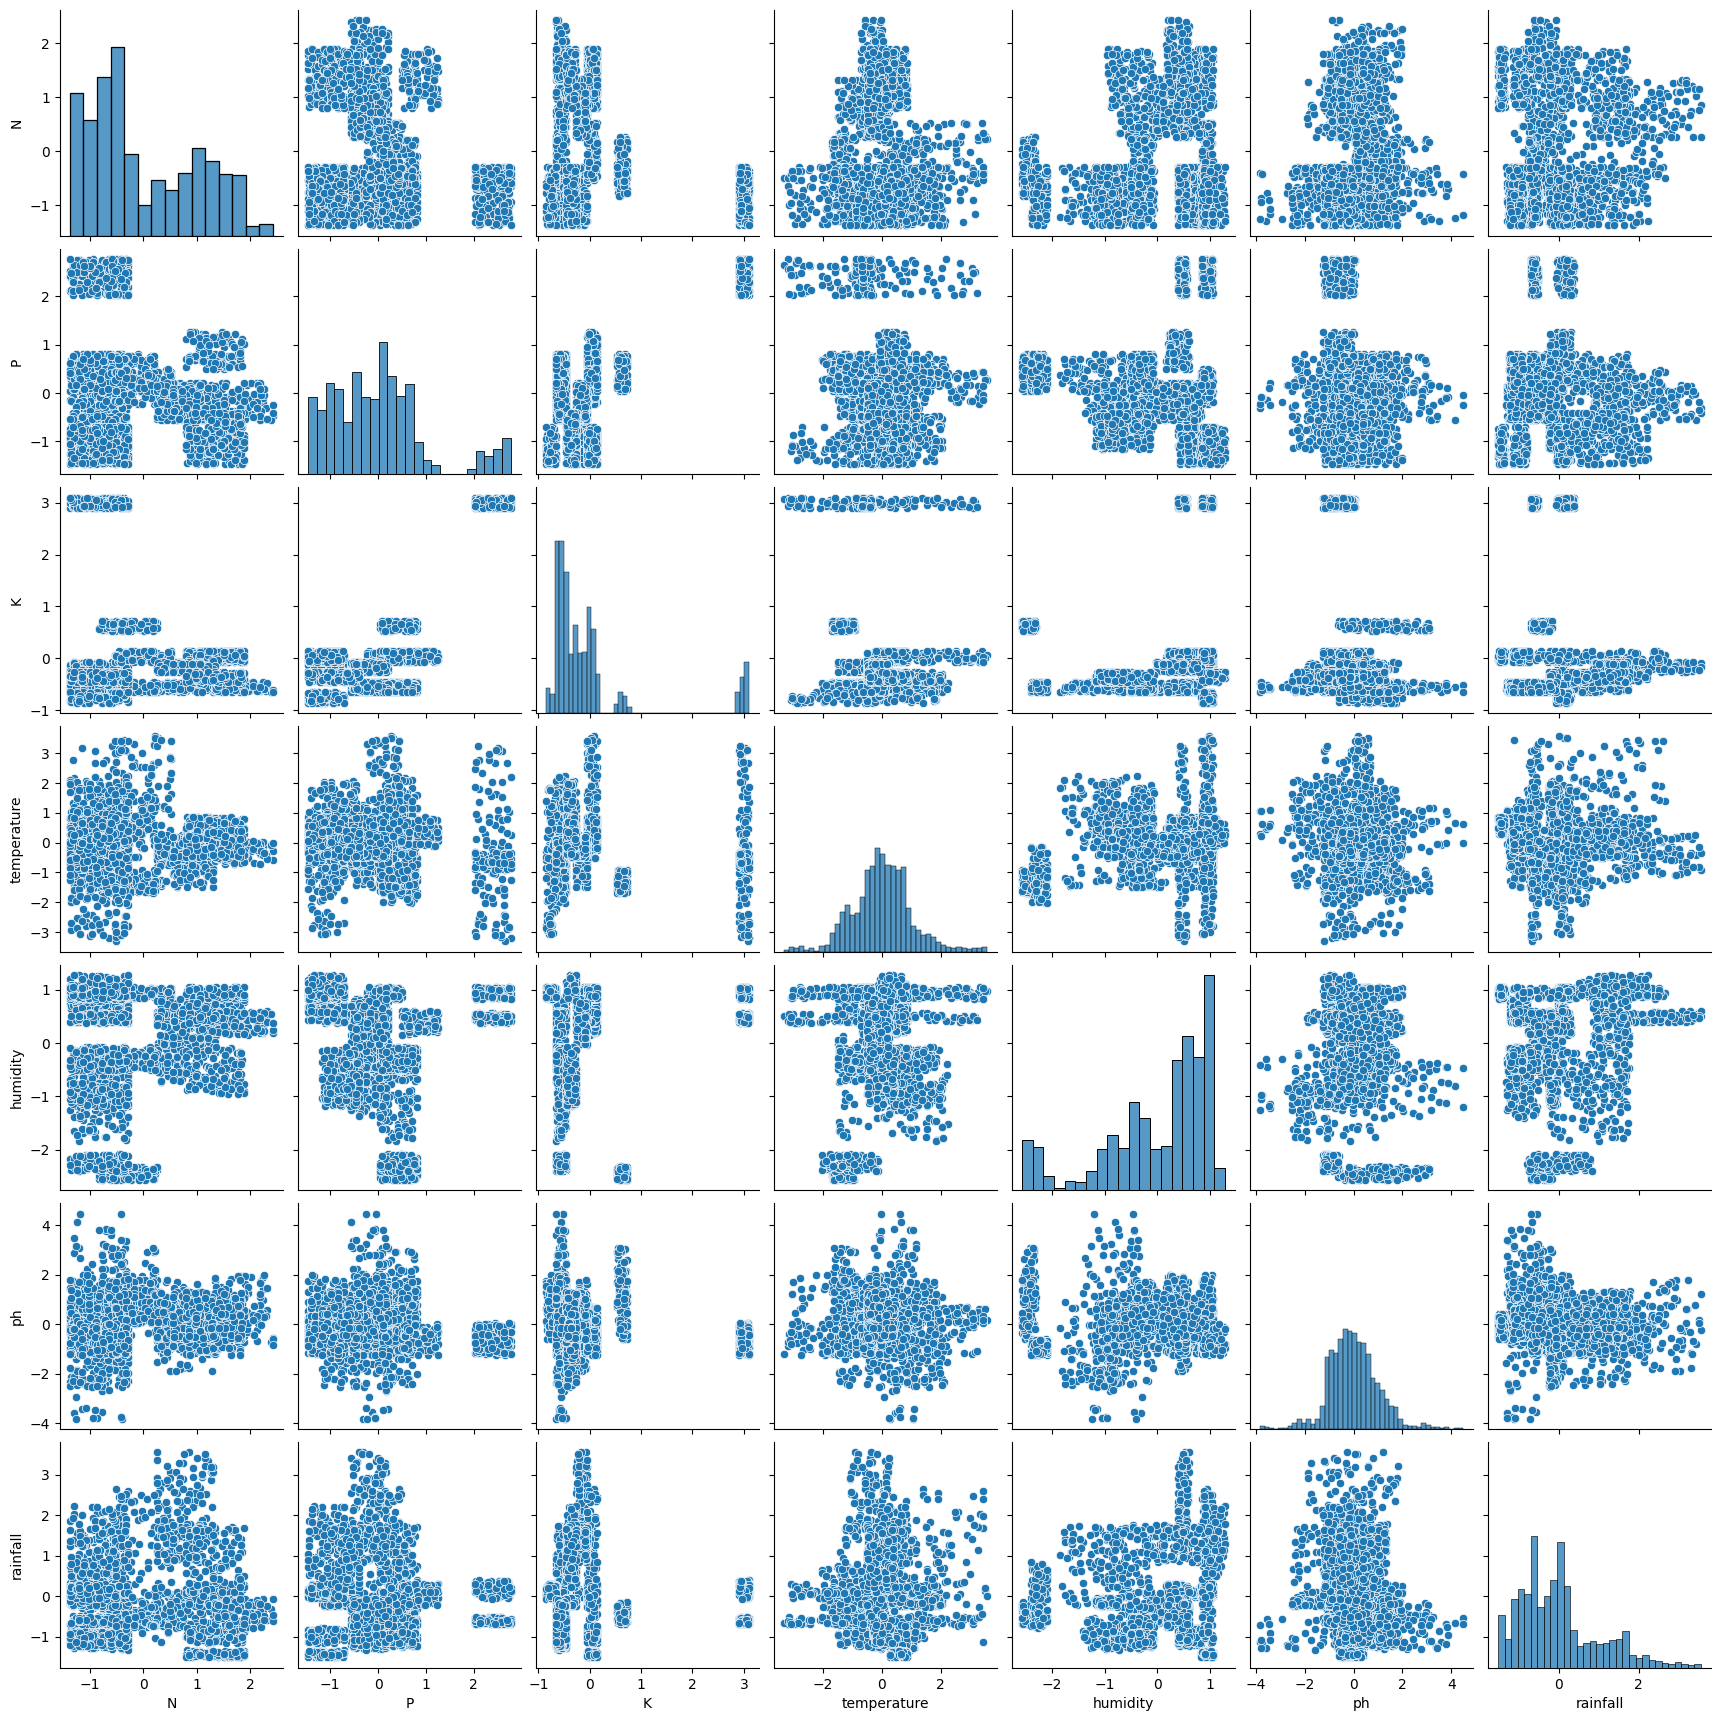

In [11]:
sbn.pairplot(dataxScaled)

## Correlación Lineal
Para poder generar una proyección PCA, debemos ver si existe correlación **lineal** entre las variables

<Axes: >

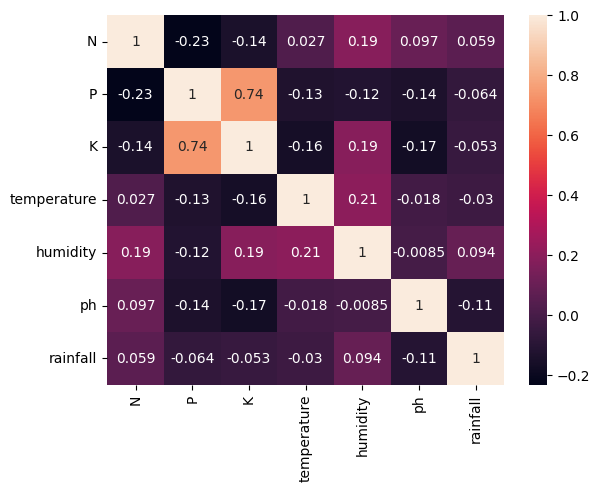

In [10]:
sbn.heatmap(dataxScaled.corr(), annot=True)

No se ve mucha correlación lineal entre los datos. En el único caso que está presente es en K con P

### Eliminar valores atípicos

In [11]:
qmin = 0.10
qmax = 1 - qmin
quant_datax = dataxScaled.quantile([qmin, qmax])
datax_nuevo = dataxScaled.apply(lambda x: x[(x >= quant_datax.loc[qmin, x.name]) & (x <= quant_datax.loc[qmax, x.name])], axis=0).dropna()
datax_nuevo.reset_index(inplace=True, drop=True)

In [12]:
datax_nuevo.head()

N         P         K  temperature  humidity        ph  rainfall
0  1.150079  0.079970 -0.239928    -0.316294  0.475098  0.665416  1.488986
1  1.041704 -0.253582 -0.239928    -0.847629  0.404020 -0.034901  1.492993
2  1.095891 -0.556811 -0.200431    -0.142014  0.406316 -0.433199  1.459903
3  1.312641 -0.374874 -0.239928    -0.228780  0.506164  0.347875  1.439561
4  0.472736  0.110293 -0.101688     0.093319  0.399754 -0.985493  1.445799

In [13]:
datax_nuevo.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 531 entries, 0 to 530
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   N            531 non-null    float64
 1   P            531 non-null    float64
 2   K            531 non-null    float64
 3   temperature  531 non-null    float64
 4   humidity     531 non-null    float64
 5   ph           531 non-null    float64
 6   rainfall     531 non-null    float64
dtypes: float64(7)
memory usage: 29.2 KB


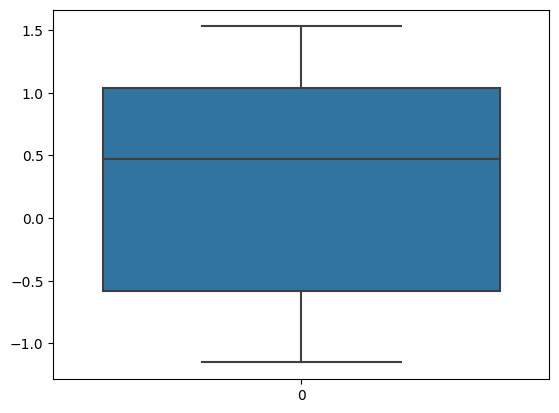

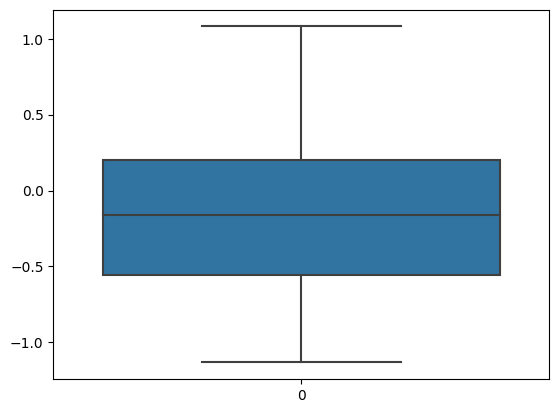

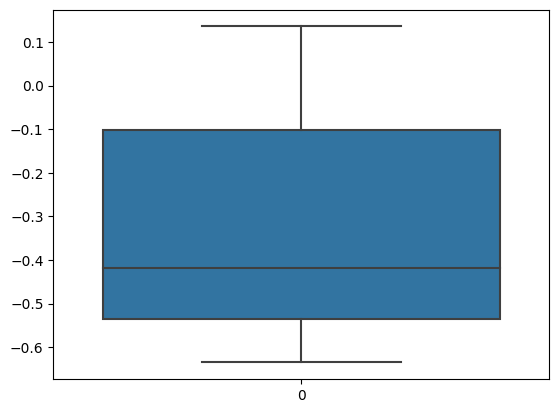

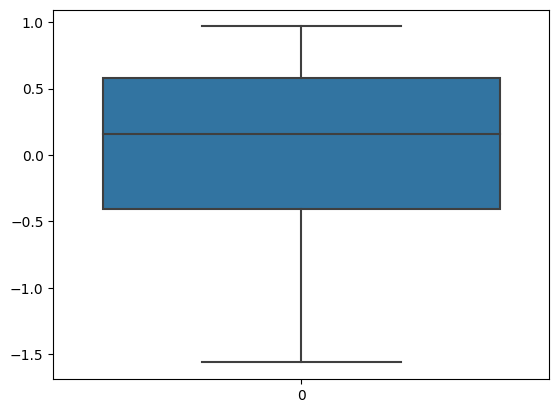

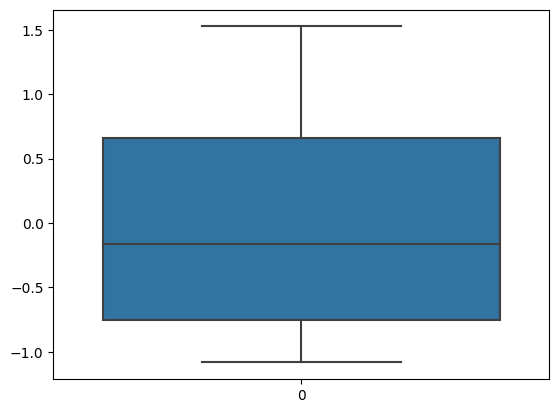

In [14]:
for column in datax_nuevo.columns:
    plt.figure()
    sbn.boxplot(datax_nuevo[column])
    plt.show()

In [17]:
sbn.pairplot(datax_nuevo)

/home/simon/.local/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


<Axes: >

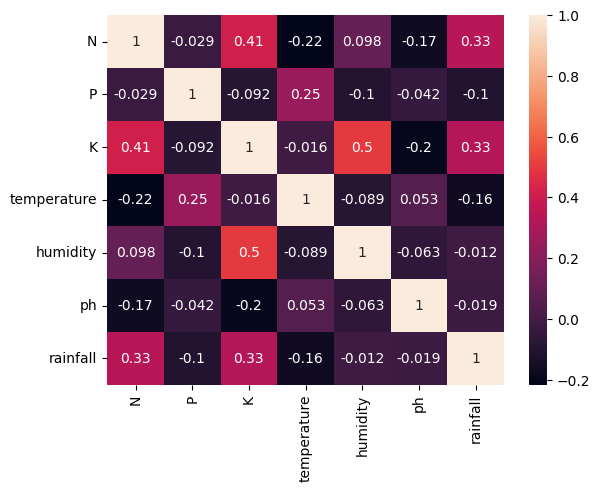

In [15]:
sbn.heatmap(datax_nuevo.corr(), annot=True)

## PCA

In [16]:
pca = PCA(n_components=datax_nuevo.shape[1])
pca_result = pca.fit_transform(datax_nuevo)
pca_df = pd.DataFrame(data=pca_result, columns=[f"PC{i+1}" for i, _ in enumerate(datax_nuevo.columns)])
pca_df["label"] = data["label"]
pca_df.head()

PC1       PC2       PC3       PC4       PC5       PC6       PC7 label
0 -1.580522  0.780394  0.111750 -0.332270  0.621433  0.401371  0.124351  rice
1 -1.713910  0.618507  0.405004  0.231234 -0.032002  0.562084  0.102258  rice
2 -1.687793  0.451572  0.268125  0.569706  0.046506 -0.202029  0.149135  rice
3 -1.738570  0.590749  0.305715 -0.163145  0.365863  0.013782  0.174323  rice
4 -1.200475  0.441173 -0.162035  1.352708  0.336609  0.061220  0.028410  rice

In [17]:
varianza = np.cumsum(pca.explained_variance_ratio_)
acum = pd.DataFrame({"EigenValues": pca.explained_variance_, "PropVar": pca.explained_variance_ratio_, "VarAcum": varianza})
acum

EigenValues   PropVar   VarAcum
0     0.974827  0.354543  0.354543
1     0.492174  0.179003  0.533545
2     0.387359  0.140882  0.674427
3     0.345243  0.125564  0.799991
4     0.309245  0.112472  0.912463
5     0.211257  0.076834  0.989296
6     0.029430  0.010704  1.000000

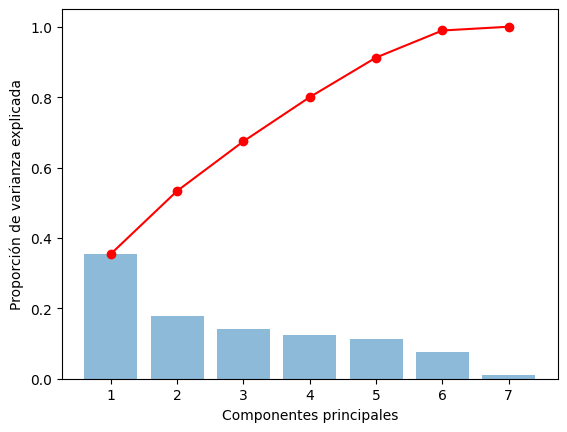

In [62]:
plt.bar(range(1, 8), pca.explained_variance_ratio_, alpha=0.5, align="center")
plt.plot(range(1, 8), varianza, marker="o" ,color="red")
plt.ylabel("Proporción de varianza explicada")
plt.xlabel("Componentes principales")
plt.show()

<Axes: >

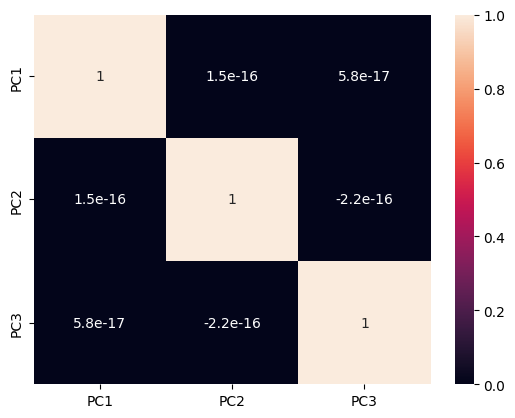

In [18]:
pcas = pca_df[["PC1", "PC2", "PC3"]]
sbn.heatmap(pcas.corr(), annot=True)

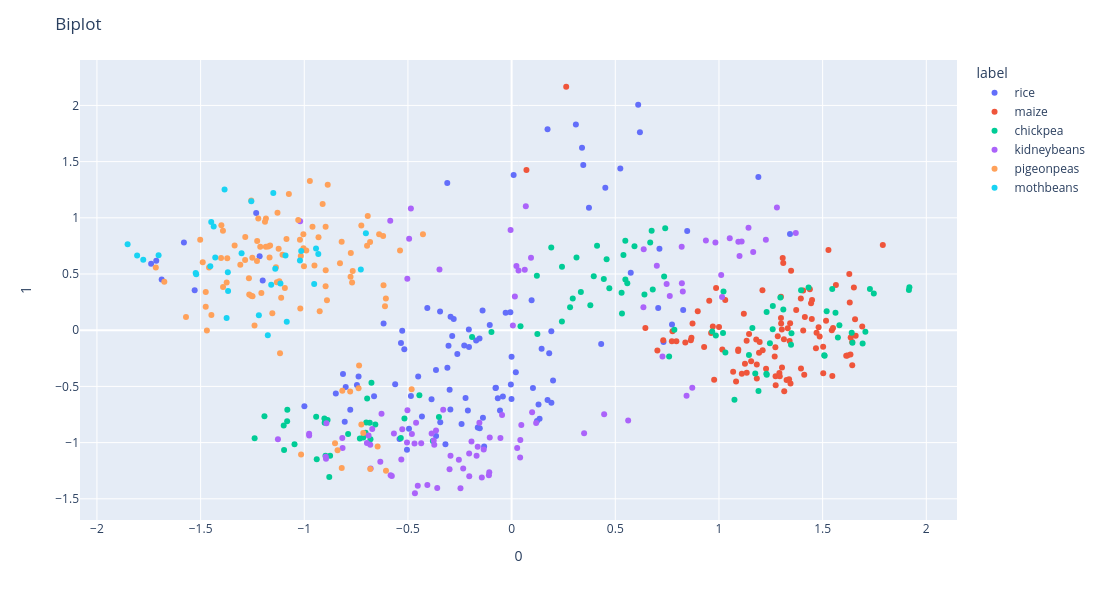

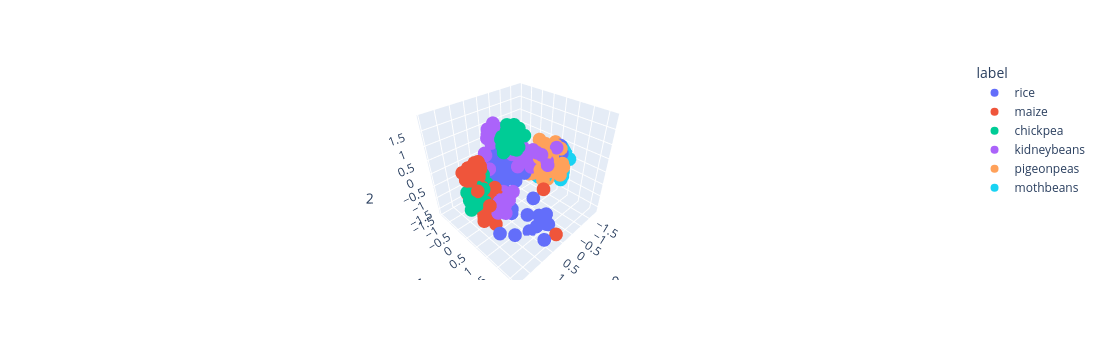

In [19]:
loadings = pca.components_.T * np.sqrt(pca.explained_variance_)
fig = px.scatter(pca_result, x=0, y=1, color=pca_df["label"], labels={"color": "label"})
fig.update_layout(title="Biplot", width=1200, height=600)
fig.show()
fig = px.scatter_3d(pca_result, x=0, y=1, z=2, color=pca_df["label"], labels={"color":"label"})
fig.show()

### Conclusión PCA:
**Cantidad de componentes**: 3 <br>
**Porcentaje de Representación**: 0.67 <br>
En base a los resultados obtenidos podemos concluir que el algoritmo *PCA* no disminuye la dimensionalidad sin perder gran cantidad de información. Esto se debe a que no encontramos mucha correlación lineal entre las variables. En principio, consideramos que este algoritmo no es mejor para el caso, sin embargo, todo depende del problema a resolver

## ISOMAP

In [24]:
N_COMPONENTS = 3
isomaps = []
for i in range(2, 7):
    isomap = Isomap(n_neighbors=i*5, n_components=N_COMPONENTS)
    isomap.fit(datax_nuevo)
    datos_isomap = isomap.transform(datax_nuevo)
    isomap_df = pd.DataFrame(datos_isomap, columns=[f"C{i + 1}" for i in range(N_COMPONENTS)])
    isomap_df["label"] = data["label"]
    isomaps.append(isomap_df)

In [25]:
for iso in isomaps:
    display(iso.head())

C1        C2        C3 label
0 -0.735340 -1.896572  0.722864  rice
1 -1.167259 -2.353185  1.147832  rice
2 -1.105698 -2.544766  1.044585  rice
3 -1.198317 -2.323926  0.547580  rice
4 -0.584359 -2.126501  2.015544  rice

C1        C2        C3 label
0 -1.872484  1.469445  0.775320  rice
1 -1.853878  1.726978  0.906555  rice
2 -2.009900  1.417111  0.809739  rice
3 -2.021743  1.542304  0.531392  rice
4 -1.705702  0.987850  1.599783  rice

C1        C2        C3 label
0 -2.199546  1.286147  0.415134  rice
1 -1.978425  1.624865  0.305057  rice
2 -1.909916  1.432051  0.287693  rice
3 -2.312682  1.225035  0.301330  rice
4 -1.921770  1.064643  0.890597  rice

C1        C2        C3 label
0 -2.073951  1.407546  0.522088  rice
1 -1.856373  1.831129  0.407613  rice
2 -1.865722  1.508160  0.442277  rice
3 -2.027370  1.375724  0.453834  rice
4 -1.768116  1.197830  0.844255  rice

C1        C2        C3 label
0 -1.854586  1.193387  0.170172  rice
1 -1.943236  1.096762  0.320079  rice
2 -2.051335  0.766384  0.279314  rice
3 -2.000109  0.989695  0.149463  rice
4 -1.918529  0.840741  0.600885  rice

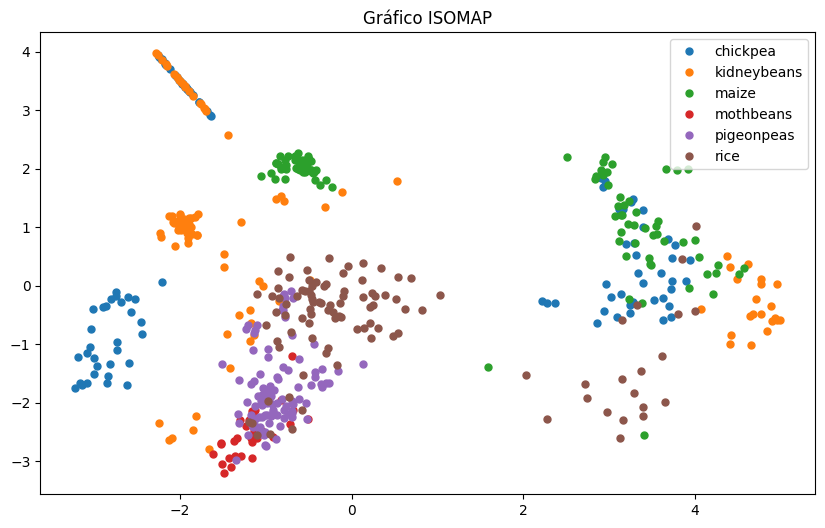

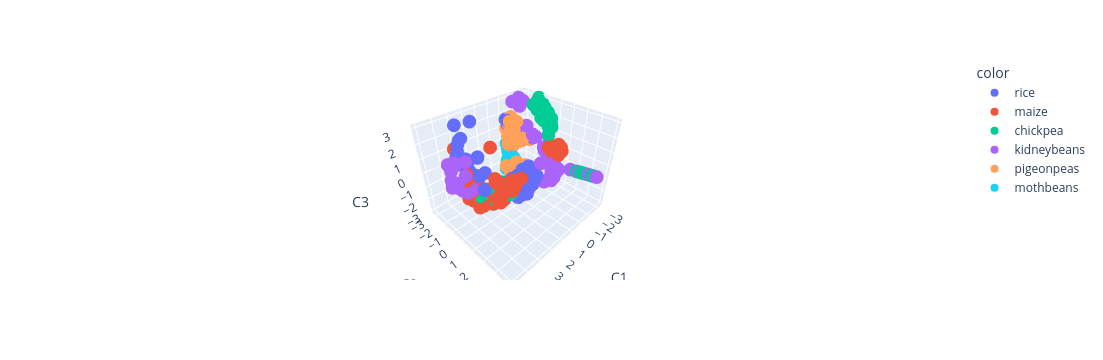

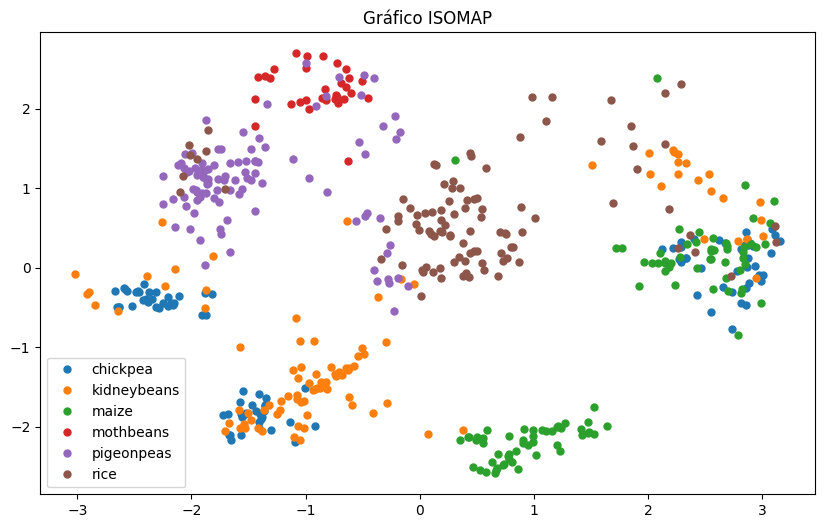

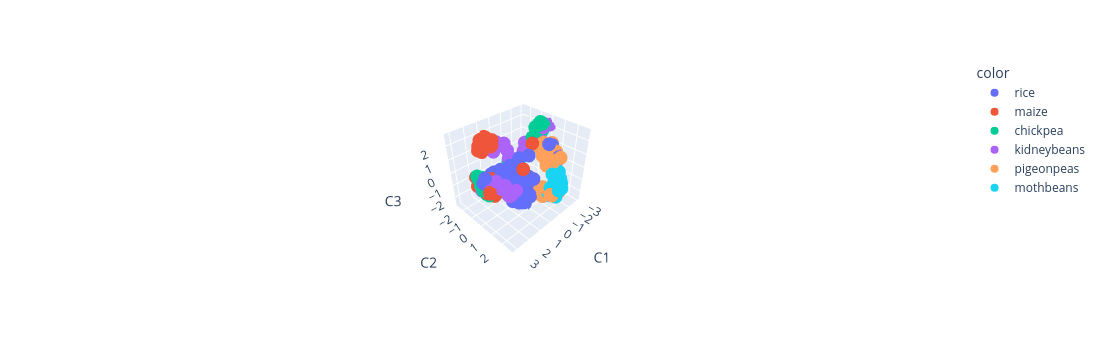

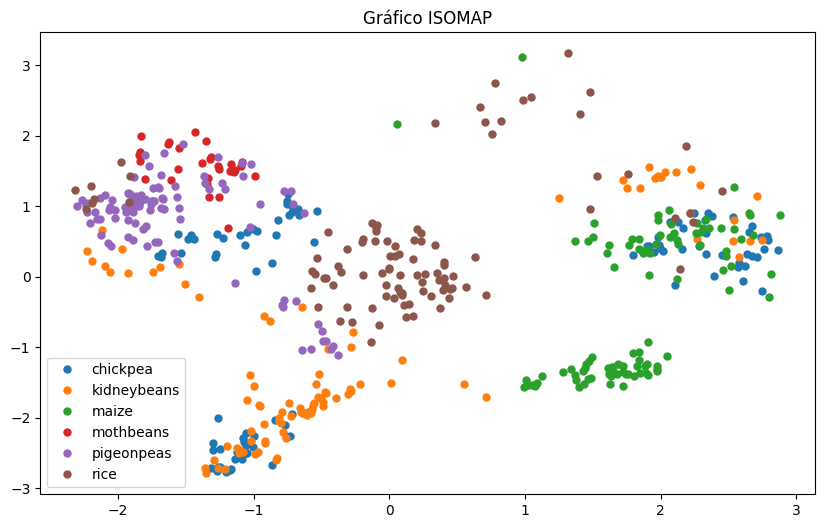

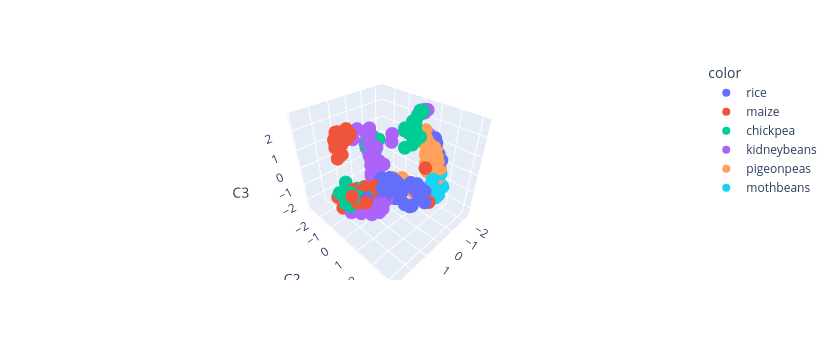

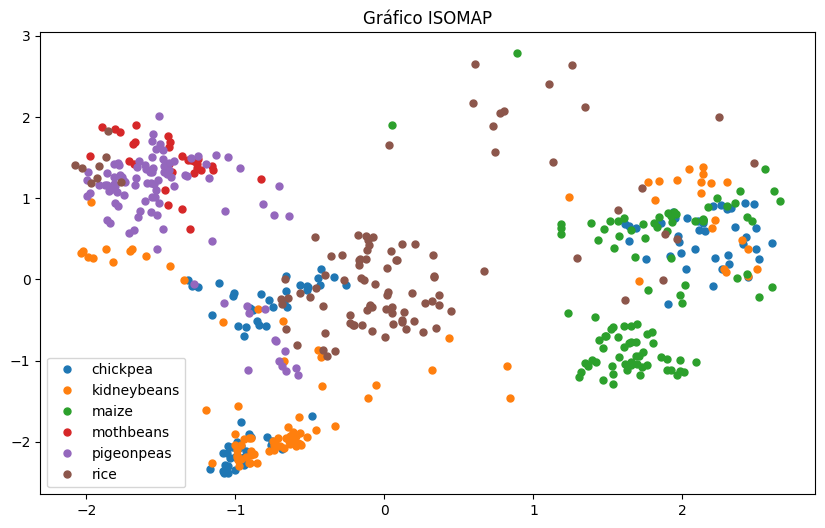

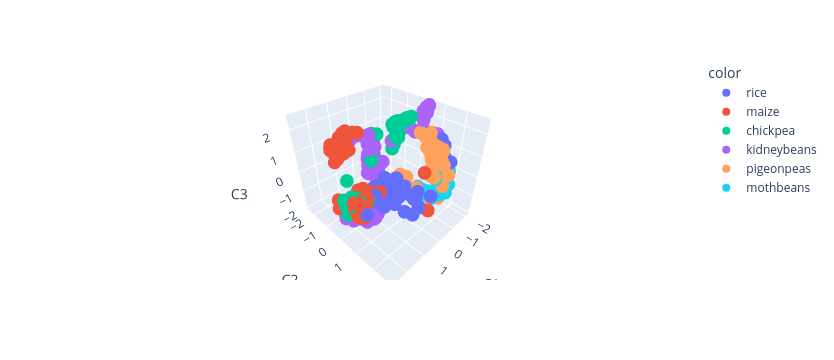

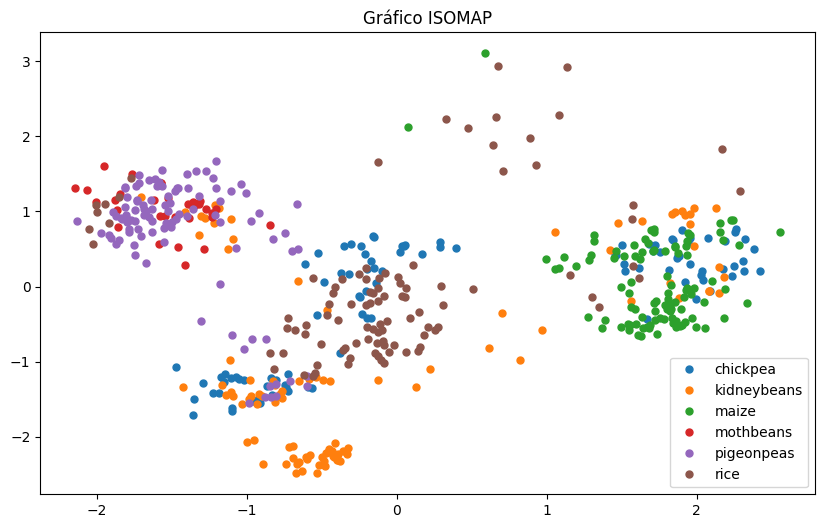

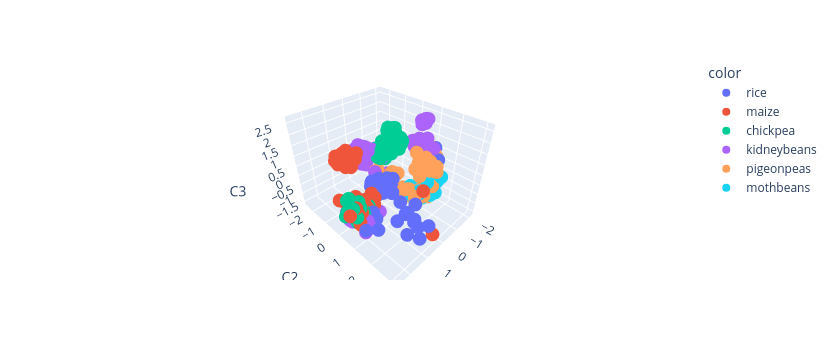

In [26]:
for iso in isomaps:
    grupos = iso.groupby("label")
    plt.figure(figsize=(10, 6))
    plt.title("Gráfico ISOMAP")
    for nombre, grupo in grupos:
        plt.plot(grupo["C1"], grupo["C2"], marker="o", linestyle="", markersize=5, label=nombre)
    plt.legend()
    plt.show()
    fig = px.scatter_3d(iso[["C1", "C2", "C3"]],  x="C1", y="C2", z="C3", color=iso["label"])
    fig.show()

### Conclusión ISOMAP
Considerando que ISOMAP es un método lineal no se logra representar correctamente la información cuando se reduce la dimensionalidad

In [67]:
divers = []
for i in range(5, 51):
    tsne = TSNE(n_components=2, verbose=0, perplexity=i, n_iter=1000)
    tsne_data = tsne.fit_transform(datax_nuevo)
    tsne_df = pd.DataFrame(data=tsne_data, columns=["tsne-1", "tsne-2"])
    divers.append(tsne.kl_divergence_)
    print("Iteración", i)

Iteración 5
Iteración 6
Iteración 7
Iteración 8
Iteración 9
Iteración 10
Iteración 11
Iteración 12
Iteración 13
Iteración 14
Iteración 15
Iteración 16
Iteración 17
Iteración 18
Iteración 19
Iteración 20
Iteración 21
Iteración 22
Iteración 23
Iteración 24
Iteración 25
Iteración 26
Iteración 27
Iteración 28
Iteración 29
Iteración 30
Iteración 31
Iteración 32
Iteración 33
Iteración 34
Iteración 35
Iteración 36
Iteración 37
Iteración 38
Iteración 39
Iteración 40
Iteración 41
Iteración 42
Iteración 43
Iteración 44
Iteración 45
Iteración 46
Iteración 47
Iteración 48
Iteración 49
Iteración 50


In [68]:
tsne_df.head()

tsne-1     tsne-2
0 -10.311032   7.660734
1 -12.155285   9.264451
2 -11.751439  10.753291
3 -10.971595   8.457296
4 -11.831299  12.836766

In [44]:
tsne_df["label"] = data["label"]

<Axes: xlabel='tsne-1', ylabel='tsne-2'>

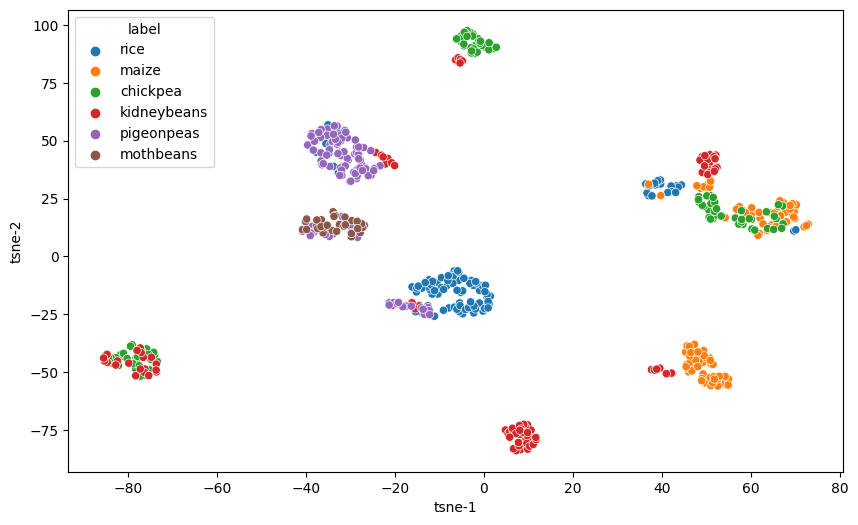

In [45]:
plt.figure(figsize=(10, 6))
sbn.scatterplot(data=tsne_df, x="tsne-1", y="tsne-2", hue="label")

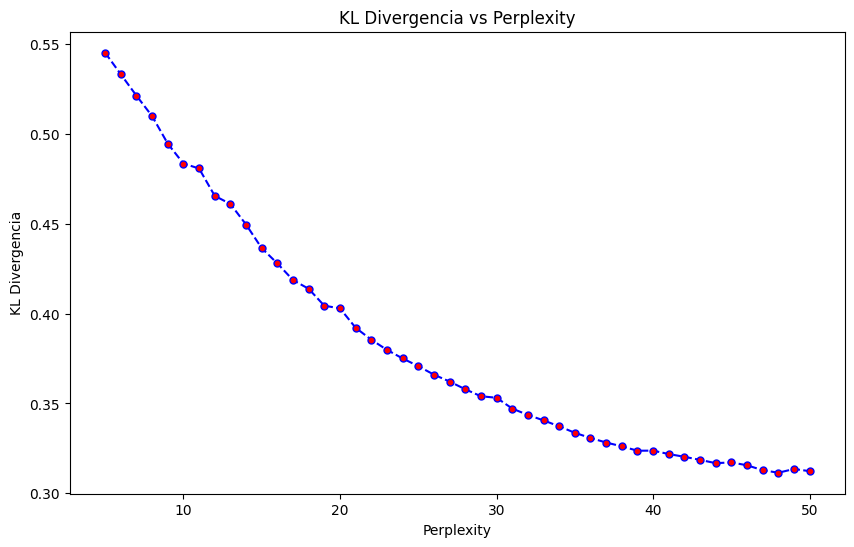

In [73]:
plt.figure(figsize=(10, 6))
plt.plot(range(5, 51), divers, color="blue", linestyle="dashed", marker="o", markerfacecolor="red", markersize=5)
plt.title("KL Divergencia vs Perplexity")
plt.xlabel("Perplexity")
plt.ylabel("KL Divergencia")
plt.show()

In [70]:
diversnp = np.array(divers)

In [71]:
print(diversnp.argmin() + 1, diversnp.min())

44 0.31141379475593567


## KMeans

In [29]:
kmeans = KMeans(n_clusters=data["label"].unique().shape[0])

In [28]:
data["label"].unique().shape

(22,)

In [30]:
kmeans.fit(datax_nuevo)

KMeans(n_clusters=22)

In [31]:
kmeans.transform(datax_nuevo)

array([[3.28740949, 2.04982472, 2.83642981, ..., 3.21142075, 2.58563953,
        1.6057551 ],
       [3.23535236, 2.02842997, 3.07475765, ..., 3.52267275, 2.55300577,
        1.77612317],
       [2.95453877, 2.03895139, 3.05934517, ..., 3.4817491 , 2.77064784,
        1.71236057],
       ...,
       [2.54971227, 1.98110425, 2.79160615, ..., 3.13826775, 2.41973857,
        0.98879087],
       [2.92599447, 2.01056754, 2.92302885, ..., 3.21814975, 2.82475999,
        0.92180276],
       [2.70550331, 1.65012835, 2.81379971, ..., 3.11907691, 2.75539079,
        0.68962333]])

In [39]:
dfxk = datax_nuevo.copy()

In [40]:
dfxk["nueva_tag"] = kmeans.predict(datax_nuevo)

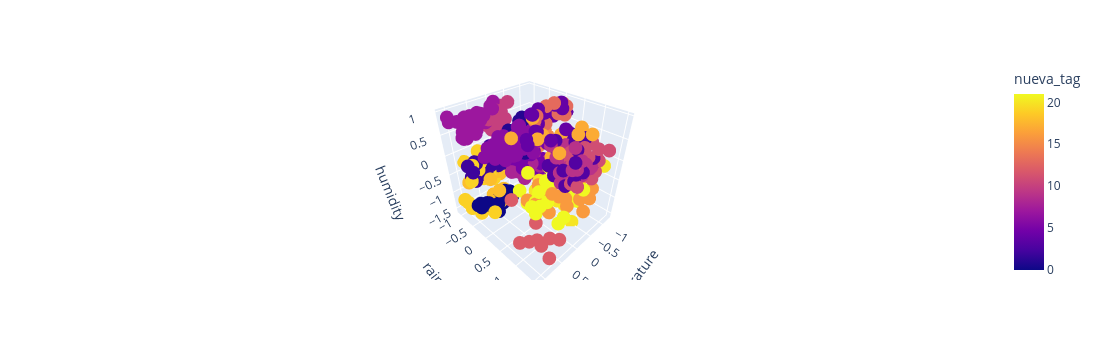

In [43]:
#sbn.scatterplot(dfxk, x="temperature", y="rainfall" hue="nueva_tag", palette="rainbow")
px.scatter_3d(dfxk, x="temperature", y="rainfall", z="humidity", color="nueva_tag")

In [42]:
datax_nuevo.head()

N         P         K  temperature  humidity        ph  rainfall
0  1.150079  0.079970 -0.239928    -0.316294  0.475098  0.665416  1.488986
1  1.041704 -0.253582 -0.239928    -0.847629  0.404020 -0.034901  1.492993
2  1.095891 -0.556811 -0.200431    -0.142014  0.406316 -0.433199  1.459903
3  1.312641 -0.374874 -0.239928    -0.228780  0.506164  0.347875  1.439561
4  0.472736  0.110293 -0.101688     0.093319  0.399754 -0.985493  1.445799

In [47]:
kmeansarray = [KMeans(n_clusters=i) for i in range(1, 30)]

In [48]:
scores = [kmeans.fit(datax_nuevo).score(datax_nuevo) for kmeans in kmeansarray]

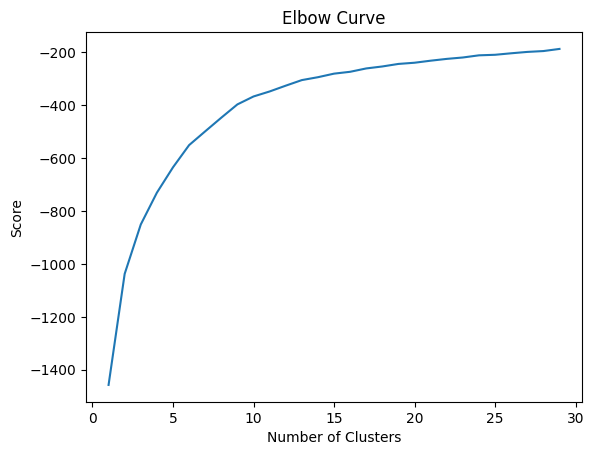

In [49]:
plt.plot(range(1, 30),scores)
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('Elbow Curve')
plt.show()

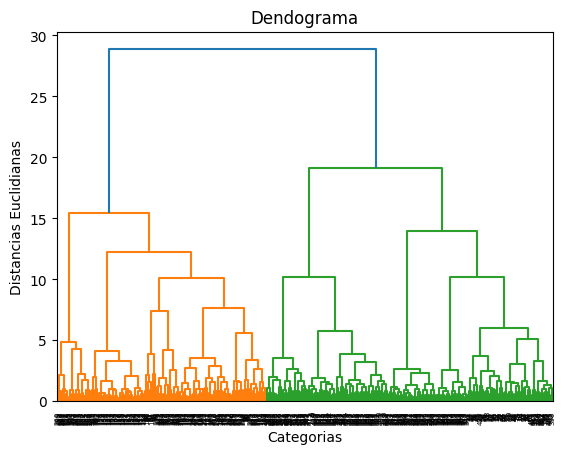

In [51]:
dendrogram = sch.dendrogram(sch.linkage(datax_nuevo, method = 'ward'))
plt.title('Dendograma')
plt.xlabel('Categorias')
plt.ylabel('Distancias Euclidianas')
plt.show()

In [59]:
hc = AgglomerativeClustering(n_clusters = 22, metric= 'euclidean', linkage = 'ward')

In [60]:
datax_nuevo["nueva_tag_cluster"] = hc.fit_predict(datax_nuevo)

<Axes: xlabel='temperature', ylabel='rainfall'>

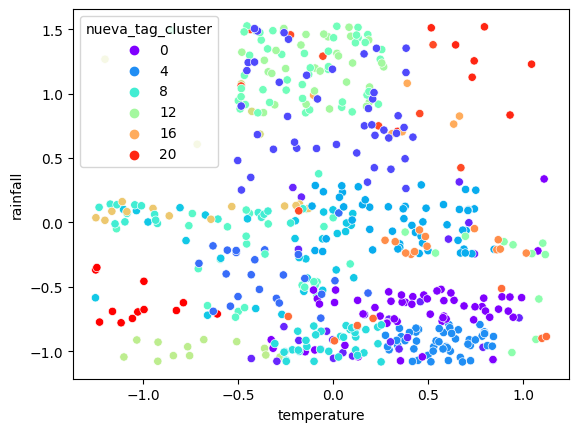

In [61]:
sbn.scatterplot(datax_nuevo, x="temperature", y="rainfall", hue="nueva_tag_cluster", palette="rainbow")

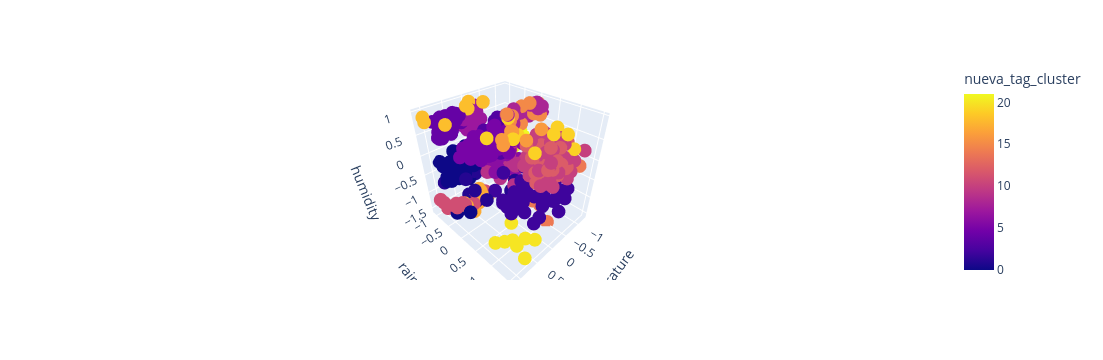

In [62]:
px.scatter_3d(datax_nuevo, x="temperature", y="rainfall", z="humidity", color="nueva_tag_cluster")